In [1]:
# Load environment variables from parent directory and set up auto-reload
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

## Context Offloading: Filesystem

#TODO(Geoff): Can add more here. 

* Agent context can grow quickly.
* The average Manus task uses ~50 tool calls! 
* A useful trick is to avoid writing all tool call observations to the context window. 
* Agents use the filesystem for **context offloading**. 
* This allows them to save information outside their context window.
* But they can just [fetch it as-needed](https://blog.langchain.com/context-engineering-for-agents/). 
* [Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) and [Hugging Face Open Deep Research](https://huggingface.co/blog/open-deep-research) do this.
* Write token-heavy context to files (e.g., in a sandboxed environment).

### Write File Tools

* Primary insight is that we mock the filesystem within LangGraph state. 
* Just us a dict where the key is a str with mock file path. 
* This works for short-term (thread-wise) persistence.
* Not suited for things we need to remember over across threads.
* We use LangGraph's `Command` type to update the state in the tool call.  

#TODO(Geoff): Explain InjectedState

In [2]:
%%writefile ../src/deep_agents_from_scratch/file_tools.py

from langchain_core.tools import tool
from typing_extensions import TypedDict, Annotated
from langchain_core.messages import ToolMessage
from typing import Annotated
from langchain_core.tools import InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from deep_agents_from_scratch.state import DeepAgentState

@tool
def ls(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
    """List all files in the virtual filesystem."""
    
    return list(state.get("files", {}).keys())

@tool  
def read_file(
    file_path: str,
    state: Annotated[DeepAgentState, InjectedState],
    offset: int = 0,
    limit: int = 2000,
) -> str:

    """Read file content with optional offset and limit."""
    files = state.get("files", {})
    if file_path not in files:
        return f"Error: File '{file_path}' not found"
    
    content = files[file_path]
    if not content:
        return "System reminder: File exists but has empty contents"
    
    lines = content.splitlines()
    start_idx = offset
    end_idx = min(start_idx + limit, len(lines))
    
    if start_idx >= len(lines):
        return f"Error: Line offset {offset} exceeds file length ({len(lines)} lines)"
    
    result_lines = []
    for i in range(start_idx, end_idx):
        line_content = lines[i][:2000]  # Truncate long lines
        result_lines.append(f"{i+1:6d}\t{line_content}")
    
    return "\n".join(result_lines)

@tool
def write_file(
    file_path: str,
    content: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:

    """Write content to a file in the virtual filesystem."""
    files = state.get("files", {})
    files[file_path] = content
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )

@tool
def edit_file(
    file_path: str,
    old_string: str,
    new_string: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    replace_all: bool = False,
) -> Command:

    """Edit a file by replacing old_string with new_string."""
    files = state.get("files", {})
    if file_path not in files:
        return Command(
            update={"messages": [
                ToolMessage(f"Error: File '{file_path}' not found", tool_call_id=tool_call_id)
            ]}
        )
    
    content = files[file_path]
    if old_string not in content:
        return Command(
            update={"messages": [
                ToolMessage(f"Error: String not found in file: '{old_string}'", tool_call_id=tool_call_id)
            ]}
        )
    
    if not replace_all and content.count(old_string) > 1:
        return Command(
            update={"messages": [
                ToolMessage(f"Error: String appears multiple times. Use replace_all=True", tool_call_id=tool_call_id)
            ]}
        )
    
    if replace_all:
        new_content = content.replace(old_string, new_string)
    else:
        new_content = content.replace(old_string, new_string, 1)
    
    files[file_path] = new_content
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )

Overwriting ../src/deep_agents_from_scratch/file_tools.py


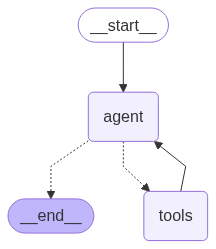

In [5]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from utils import format_messages

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.state import DeepAgentState

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)
tools = [ls, read_file, write_file]

# System prompt for the agent with file tools guidance
system_prompt = """You are a research assistant with access to a virtual file system.

Save the user's question to a file called "question.txt" before answering."""

# Create agent with system prompt
agent = create_react_agent(model, tools, prompt=system_prompt, state_schema=DeepAgentState)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Example usage
result = agent.invoke({
    "messages": [{"role": "user", "content": "Tell me about model context protocol (MCP) and how it works."}],
    "files": {}
})

format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Tell me about model context protocol (MCP) and how it works.                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll save your question first and then provide you with information about the Model Context Protocol (MCP).     │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "question.txt",                                                                                  │
│   "content": "Tell me about model context protocol (MCP) and how it works."                                     │
│ }                                                                                                               │
│    ID: toolu_01QUUV8MocCARog625ZxaoXi                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file question.txt                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Model Context Protocol (MCP)                                                                                  │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an open standard that enables AI assistants to securely connect with        │
│ external data sources and tools. Here's how it works:                                                           │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ MCP is a protocol designed to standardize how AI models interact with external systems, allowing them to:       │
│ - Access real-time data                                                                                         │
│ - Execute functions and tools                                                                                   │
│ - Integrate with various applications and services                                                              │
│ - Maintain security and privacy boundaries                                                                      │
│                                                                                                                 │
│ ## Key Components                                                                                               │
│                                                                                                                 │
│ ### 1. **MCP Servers**                                                                                          │
│ - Applications that expose specific capabilities (tools, resources, prompts)                                    │
│ - Can be local programs, cloud services, or APIs                                                                │
│ - Examples: database connectors, file systems, web scrapers, calculators                                        │
│                                                                                                                 │
│ ### 2. **MCP Clients**                                                                                          │
│ - AI applications that consume MCP server capabilities                                                          │
│ - Examples: Claude Desktop, other AI assistants, custom applications                                            │
│                                                                                                                 │
│ ### 3. **Transport Layer**                                                                                      │
│ - Handles communication between clients and servers                                                             │
│ - Supports multiple transport methods (stdio, HTTP, WebSocket)                                                  │
│ - Manages connection lifecycle and message routing                                                              │
│                                                                                                                 │
│ ## How MCP Works                                                                                                │
│                                                                                                                 │
│ ### Connection Flow:                                                                                            │
│ 1. **Discovery**: Client discovers available MCP servers                                                        │
│ 2. **Handshake**: Client and server negotiate capabilit